In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv("/home/eiji/project/g/preprocessed_data/GarageDoor_GD-MM.csv")
data

,hour,minute,second,sphone_signal_0,sphone_signal_1,door_state_open,door_state_closed,label
0,0.869565,0.898305,0.745763,0,1,1,0,0
1,0.869565,0.898305,0.830508,1,0,0,1,0
2,0.869565,0.898305,0.830508,0,1,1,0,0
3,0.869565,0.898305,0.915254,1,0,0,1,0
4,0.869565,0.898305,0.915254,0,1,1,0,0
...,...,...,...,...,...,...,...,...
541172,0.478261,0.050847,0.355932,1,0,0,1,0
541173,0.478261,0.050847,0.355932,1,0,0,1,0
541174,0.478261,0.050847,0.355932,1,0,0,1,0
541175,0.478261,0.050847,0.372881,1,0,0,1,0


In [ ]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
X = data[['hour', 'minute', 'second', 'sphone_signal_0', 'sphone_signal_1', 'door_state_open', 'door_state_closed']].values
y = data['label'].values

In [3]:
window_size = 30
X_windows = []
y_windows = []

for i in range(len(X) - window_size + 1):
    X_windows.append(X[i:i + window_size])
    y_windows.append(y[i + window_size - 1])  # ラベルはウィンドウの最後のデータに対応させます

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)


# トレーニングデータとテストデータに分割
X_train, X_temp, y_train, y_temp = train_test_split(X_windows, y_windows, test_size=0.3, random_state=42, stratify=y_windows)
# テストデータをさらに検証データとテストデータに分割
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# CNNモデルの構築
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  # カーネルサイズはウィンドウの一部として設定
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# モデルのコンパイル
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# モデルの概要
model.summary()

2024-10-04 13:50:01.392375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 13:50:01.414302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 13:50:01.794226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/eiji/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        44,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,309 (180.89 KB)

 Trainable params: 46,309 (180.89 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# モデルの訓練
# モデルの訓練
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1, shuffle=False)


Epoch 1/10


I0000 00:00:1728017403.010378    5244 service.cc:145] XLA service 0x714164017660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728017403.010400    5244 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-04 13:50:03.023323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 13:50:03.091972: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


 235/5919 ━━━━━━━━━━━━━━━━━━━━ 3s 652us/step - accuracy: 0.8565 - loss: 0.4048 

I0000 00:00:1728017403.451599    5244 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5919/5919 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8783 - loss: 0.2971 - val_accuracy: 0.9388 - val_loss: 0.1903
Epoch 2/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 5s 857us/step - accuracy: 0.9371 - loss: 0.1828 - val_accuracy: 0.9471 - val_loss: 0.1621
Epoch 3/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9468 - loss: 0.1559 - val_accuracy: 0.9504 - val_loss: 0.1450
Epoch 4/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 6s 940us/step - accuracy: 0.9519 - loss: 0.1403 - val_accuracy: 0.9523 - val_loss: 0.1372
Epoch 5/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 4s 651us/step - accuracy: 0.9557 - loss: 0.1298 - val_accuracy: 0.9546 - val_loss: 0.1302
Epoch 6/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 4s 726us/step - accuracy: 0.9578 - loss: 0.1229 - val_accuracy: 0.9577 - val_loss: 0.1213
Epoch 7/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 6s 935us/step - accuracy: 0.9595 - loss: 0.1178 - val_accuracy: 0.9588 - val_loss: 0.1177
Epoch 8/10
5919/5919 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9604 - loss: 0.1141 - v

In [6]:
# モデルの評価
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

2537/2537 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.9621 - loss: 0.1106
Test Accuracy: 0.9621


2537/2537 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step


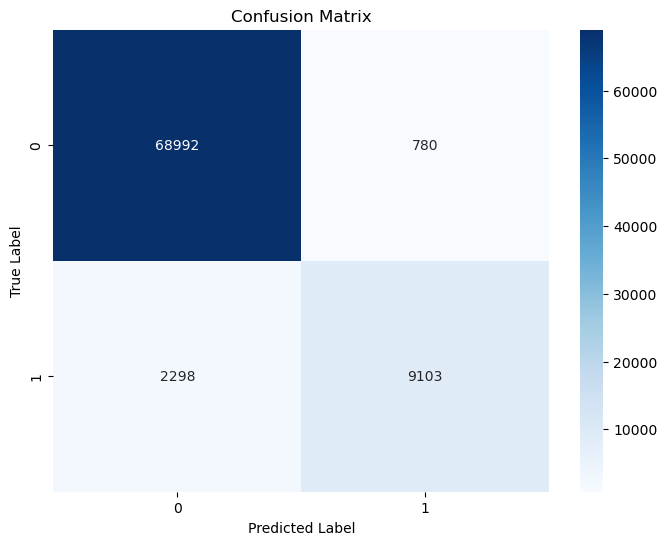

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     69772
           1       0.92      0.80      0.86     11401

    accuracy                           0.96     81173
   macro avg       0.94      0.89      0.92     81173
weighted avg       0.96      0.96      0.96     81173



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 予測の実行
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # 閾値0.5でクラスに変換

# 混同行列の計算
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 混同行列の表示
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 精度、適合率、再現率、F1スコアのレポート
print(classification_report(y_test, y_pred_classes))


In [ ]:
import tensorflow as tf

# TensorFlowのバージョンを確認
print("TensorFlow version:", tf.__version__)

# 利用可能なGPUリストを表示
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))
